# Methods for handling imbalance
> A review

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [machine-learning, classification]

I read about handling imbalance in machine learning very often. Sometimes I don't understand the reasons to approach class imbalance using fancy and sophisticated techniques. My main argument is, usually, that you should first try the simple solution (which is not approaching imbalance) before going to the most complex solution.

I've decided to do an experiment to see the impact of applying over-sampling and under-sampling to answer the following questions:
* Does over and under-sampling help increase the AUC of a model?
* Does it depend on the algorithm used?
* How do the coefficients of logistic regression change when doing over and under sampling?

### Data preparation

First of all, let's load the packages that we are going to use:

In [2]:
# Main tools
import numpy as np
import pandas as pd
import seaborn as sns

# Data
from sklego.datasets import load_arrests

# Scikit-learn classes
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Non-scikit learn classes
from category_encoders import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Over and under-samplers
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

Also, let's load the data. The data are on US arrests. These data are usually used to study ML bias. We are not going to focus on ML bias, because our interest is mainly the imbalance of the data. Keep in mind that any model trained on this data will very likely be racist if the bias is not addressed.

In [3]:
df_arrests = load_arrests(as_frame=True)
df_arrests.head()

,released,colour,year,age,sex,employed,citizen,checks
0,Yes,White,2002,21,Male,Yes,Yes,3
1,No,Black,1999,17,Male,Yes,Yes,3
2,Yes,White,2000,24,Male,Yes,Yes,3
3,No,Black,2000,46,Male,Yes,Yes,1
4,Yes,Black,1999,27,Female,Yes,Yes,1


The imbalance is not very big - 83 vs 17%, but there is some imbalance:

In [4]:
fraction = df_arrests.released.value_counts() / df_arrests.shape[0]

round(100 * fraction, 2)

Yes    82.93
No     17.07
Name: released, dtype: float64

That is, 17% of cases have not been released.

In [5]:
df_arrests_x = df_arrests.drop(columns='released')
df_arrests_y = df_arrests['released'].map({'Yes': 0, 'No': 1})
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_arrests_x, 
    df_arrests_y,
    random_state=42
)

We also create a basic class that will help make our code more uniform

In [5]:
class IdentitySampler():
    
    def __init__(self):
        pass
    
    def fit_resample(self, X, y):
        return X, y

We're going to try several samplers: over-sampling, under-sampling and *no-sampling* together with several algorithms: logistic regression, lightgbm, random forest and xgboost.

By *no-sampling* we mean not addressing the imbalance.

In [6]:
samplers = {
    'identity' : IdentitySampler(),
    'over' : RandomOverSampler(random_state=42), 
    'under' : RandomUnderSampler(random_state=42)
}

learners = {
    'logistic': LogisticRegression(),
    'lgbm': LGBMClassifier(random_state=42),
    'rf': RandomForestClassifier(random_state=42),
    'xgb': XGBClassifier(random_state=42)
    
}

### Performance comparison

In [7]:
coefficients = list()
intercepts = list()

for learner_name, learner in learners.items():
    
    # Define learner
    pipe = Pipeline([
        ('oh', OneHotEncoder()),
        ('scaler', StandardScaler()),
        ('learner', learner)
    ])

    for sampler_name, sampler in samplers.items():
        
        # Obtain resampled training data 
        X_sampled, y_sampled = sampler.fit_resample(df_train_x, df_train_y)

        pipe.fit(X_sampled, y_sampled)
        
        # Compute ROC AUC
        test_roc = roc_auc_score(df_test_y, pipe.predict_proba(df_test_x)[:,1]).round(4)

        print(
            f'ROC test {sampler_name}-sampling, {learner_name}: {test_roc}'
        )
        
        # For logistic regression, save coefficients and intercept
        if learner_name == 'logistic':

            intercept = pipe[-1].intercept_[0].round(3)

            coefficients.append(
                pipe[-1].coef_[0]
            )

            intercepts.append(intercept)
    print("----------")

ROC test identity-sampling, logistic: 0.7128
ROC test over-sampling, logistic: 0.7109
ROC test under-sampling, logistic: 0.7134
----------
ROC test identity-sampling, lgbm: 0.6936
ROC test over-sampling, lgbm: 0.6926
ROC test under-sampling, lgbm: 0.6869
----------
ROC test identity-sampling, rf: 0.6403
ROC test over-sampling, rf: 0.6277
ROC test under-sampling, rf: 0.6501
----------
ROC test identity-sampling, xgb: 0.6774
ROC test over-sampling, xgb: 0.6529
ROC test under-sampling, xgb: 0.6667
----------


For most models and datasets, the three methods have almost no difference.

* Over-sampling doesn't win in any case, and it's the worst in 3 cases.
* Under-sampling wins twice, no sampling wins twice.

### Logistic regression case

In the logistic regression case, we can have a look at the coefficients to try to understand what over and under-sampling are doing.

In [8]:
# Prepare coefficients dataframe

coefficients = pd.DataFrame(np.array(coefficients).T)
intercepts = pd.DataFrame(np.array(intercepts)).T

coefficients.columns = samplers.keys()
intercepts.columns = samplers.keys()

coefficients = intercepts.append(coefficients)

# Clean data to plot

coefficents_long = coefficients.melt(var_name='sampling', value_name='coefficient')

coefficents_long['index'] = list(range(coefficients.shape[0])) * 3
coefficents_long['intercept'] = coefficents_long['index'] == 0

We can see that most coefficients are very similar in the 3 cases, but the first coefficient changes significantly (in this case, the intercept). The effect on the coefficients of under or over-sampling is increasing the intercept. This completely makes sense - the intercept represents, in a way, the fraction of cases with target 1. By changing this fraction we are artificiallt increasing the intercept.

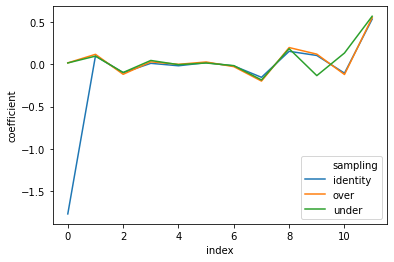

In [9]:
sns.lineplot(data=coefficents_long, y='coefficient', x='index', hue='sampling')